## Imports and Global Variables

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Task 1

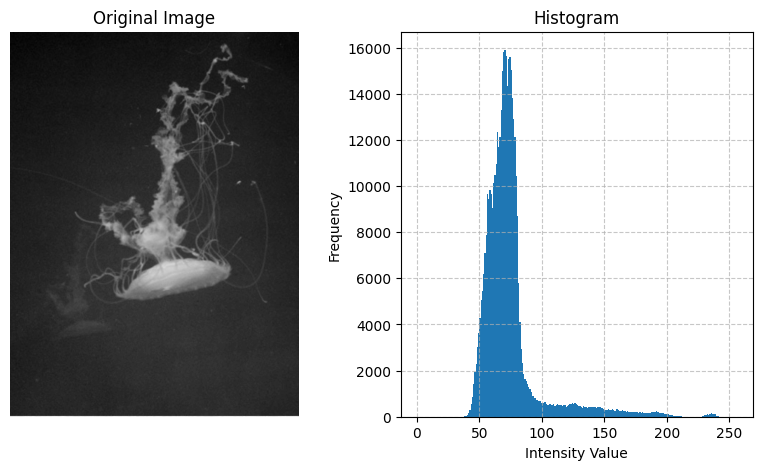

In [378]:
img_to_threshold = cv2.imread("../images/jellyfish.png", cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_to_threshold, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].hist(img_to_threshold.ravel(), bins=256, range=[0, 256])
ax[1].set_title("Histogram")
ax[1].set_xlabel("Intensity Value")
ax[1].set_ylabel("Frequency")
ax[1].grid(linestyle="--", alpha=0.7)

plt.show()
plt.close(fig)

### Binary Threshold

In [ ]:
# Works only for grayscale image
def binary_threshold(img, threshold=255):
    thresholded_img = np.where(img < threshold, 0, 255)
    return thresholded_img

### Adaptive Threshold

In [139]:
def adaptive_threshold(img, k=5):
    padded_img = np.pad(img, pad_width=k//2, mode='constant', constant_values=0)
    img_height, img_width = padded_img.shape
    thresholded_img = np.zeros((img_height - k + 1, img_width - k + 1), dtype=np.uint8)
    for i in range(k//2, img_height - k//2):
        for j in range(k//2, img_width - k//2):
            window = padded_img[i - k//2 : i + k//2 + 1, j - k//2 : j + k//2 + 1]
            thresholded_img[i - k//2, j - k//2] = 255 if padded_img[i, j] > np.mean(window) else 0
    return thresholded_img

### OTSU Threshold

In [ ]:
def otsu_threshold(img):
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    total_pixels = img.size
    probabilities = hist / total_pixels

    cumulative_sum = np.cumsum(probabilities)
    cumulative_mean = np.cumsum(np.arange(256) * probabilities)

    mG = cumulative_mean[-1] # Global mean

    max_sigma_b = 0
    t1 = 0
    t2 = 0

    for t in range(1, 256):
        if cumulative_sum[t] == 0 or cumulative_sum[t] == 1:
            continue # Avoid division by zero

        # Class probabilities P1(t) and P2(t)
        p1 = cumulative_sum[t]
        p2 = 1 - p1

        # Class means m1(t) and m2(t)
        m1 = cumulative_mean[t] / p1
        m2 = (mG - cumulative_mean[t]) / p2

        # Between-class variance
        sigma_b = p1 * (m1 - mG) ** 2 + p2 * (m2 - mG) ** 2

        if sigma_b >= max_sigma_b:
            t2 = t
            if sigma_b > max_sigma_b:
                max_sigma_b = sigma_b
                t1 = t

    optimal_threshold = (t1 + t2) // 2
    return binary_threshold(img, optimal_threshold), optimal_threshold

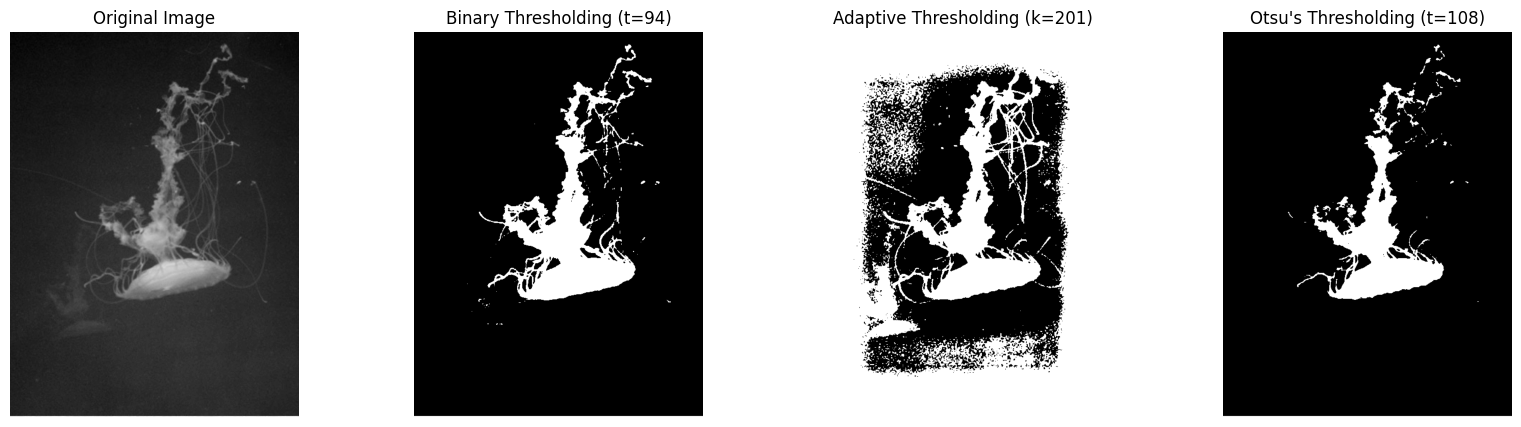

In [143]:
# Generating thresholded images
bin_threshold_val = 94 # Manually selected the value by hit and trial
bin_thresholded_img = binary_threshold(img_to_threshold, bin_threshold_val)

adap_thresholding_kernel_size = 201
adap_thresholded_img = adaptive_threshold(img_to_threshold, adap_thresholding_kernel_size)

otsu_thresholded_img, otsu_threshold_val = otsu_threshold(img_to_threshold)

# Displaying the thresholded images
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(img_to_threshold, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(bin_thresholded_img, cmap="gray")
ax[1].set_title(f"Binary Thresholding (t={bin_threshold_val})")
ax[1].axis("off")

ax[2].imshow(adap_thresholded_img, cmap="gray")
ax[2].set_title(f"Adaptive Thresholding (k={adap_thresholding_kernel_size})")
ax[2].axis("off")

ax[3].imshow(otsu_thresholded_img, cmap="gray")
ax[3].set_title(f"Otsu's Thresholding (t={otsu_threshold_val})")
ax[3].axis("off")

plt.show()
plt.close(fig)

**1. Binary Thresholding**  
Works well but requires manual threshold adjustment. It preserves small details like jellyfish strands, making it the best for this image.

**2. Adaptive Thresholding**  
Acceptable results but prone to noise and slower processing with large kernel sizes.

**3. Otsu’s Method**  
Efficient and automatic, but misses small details and misclassifies dark regions of the jellyfish as background.

**Conclusion:**  
Binary thresholding provides the best results by preserving small details, while Otsu’s and adaptive thresholding fall short in accuracy.

## Task 2

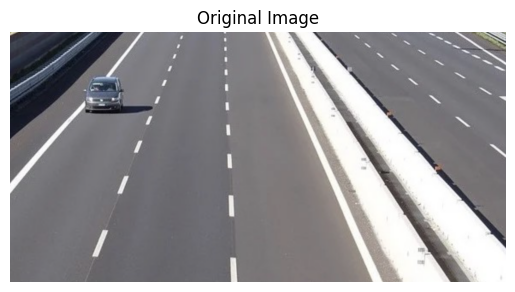

In [223]:
lane_img = cv2.imread("../images/lane.png")
lane_img = cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB)

plt.imshow(lane_img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.show()
plt.close()

In [ ]:
def hough_line_transform(img, canny_threshold1=50, canny_threshold2=200, rho=1, theta=np.pi/180, threshold=68, min_line_length=15, max_line_gap=250):
    copy_img = np.copy(img)
    gray_img = cv2.cvtColor(copy_img, cv2.COLOR_BGR2GRAY)

    # Apply canny edge detector
    edges = cv2.Canny(gray_img, canny_threshold1, canny_threshold2)

    # rho: Distance resolution in pixels, controls line detection accuracy.
    # theta: Angle resolution in radians (typically np.pi/180 for 1 degree).
    # threshold: Minimum number of votes required to detect a line.
    # minLineLength: Minimum length for a line to be considered valid.
    # maxLineGap: Maximum allowed gap between segments of the same line.
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)

    # Draw lines on the image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(copy_img, (x1, y1), (x2, y2), (255, 0, 0), 2) # Red colored lines of thickness 2

    return copy_img

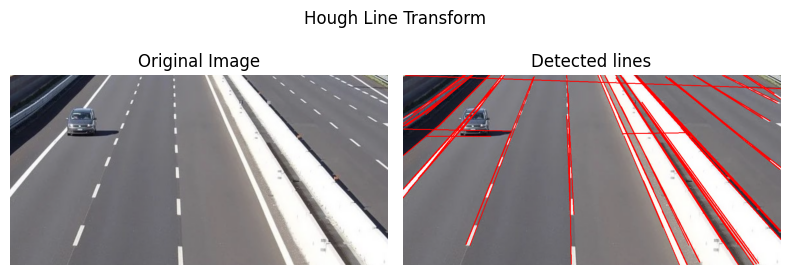

In [ ]:
hough_line_transformed_img = hough_line_transform(lane_img)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].imshow(lane_img)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(hough_line_transformed_img)
ax[1].set_title("Detected lines")
ax[1].axis("off")

plt.suptitle("Hough Line Transform")

plt.tight_layout()
plt.show()
plt.close(fig)

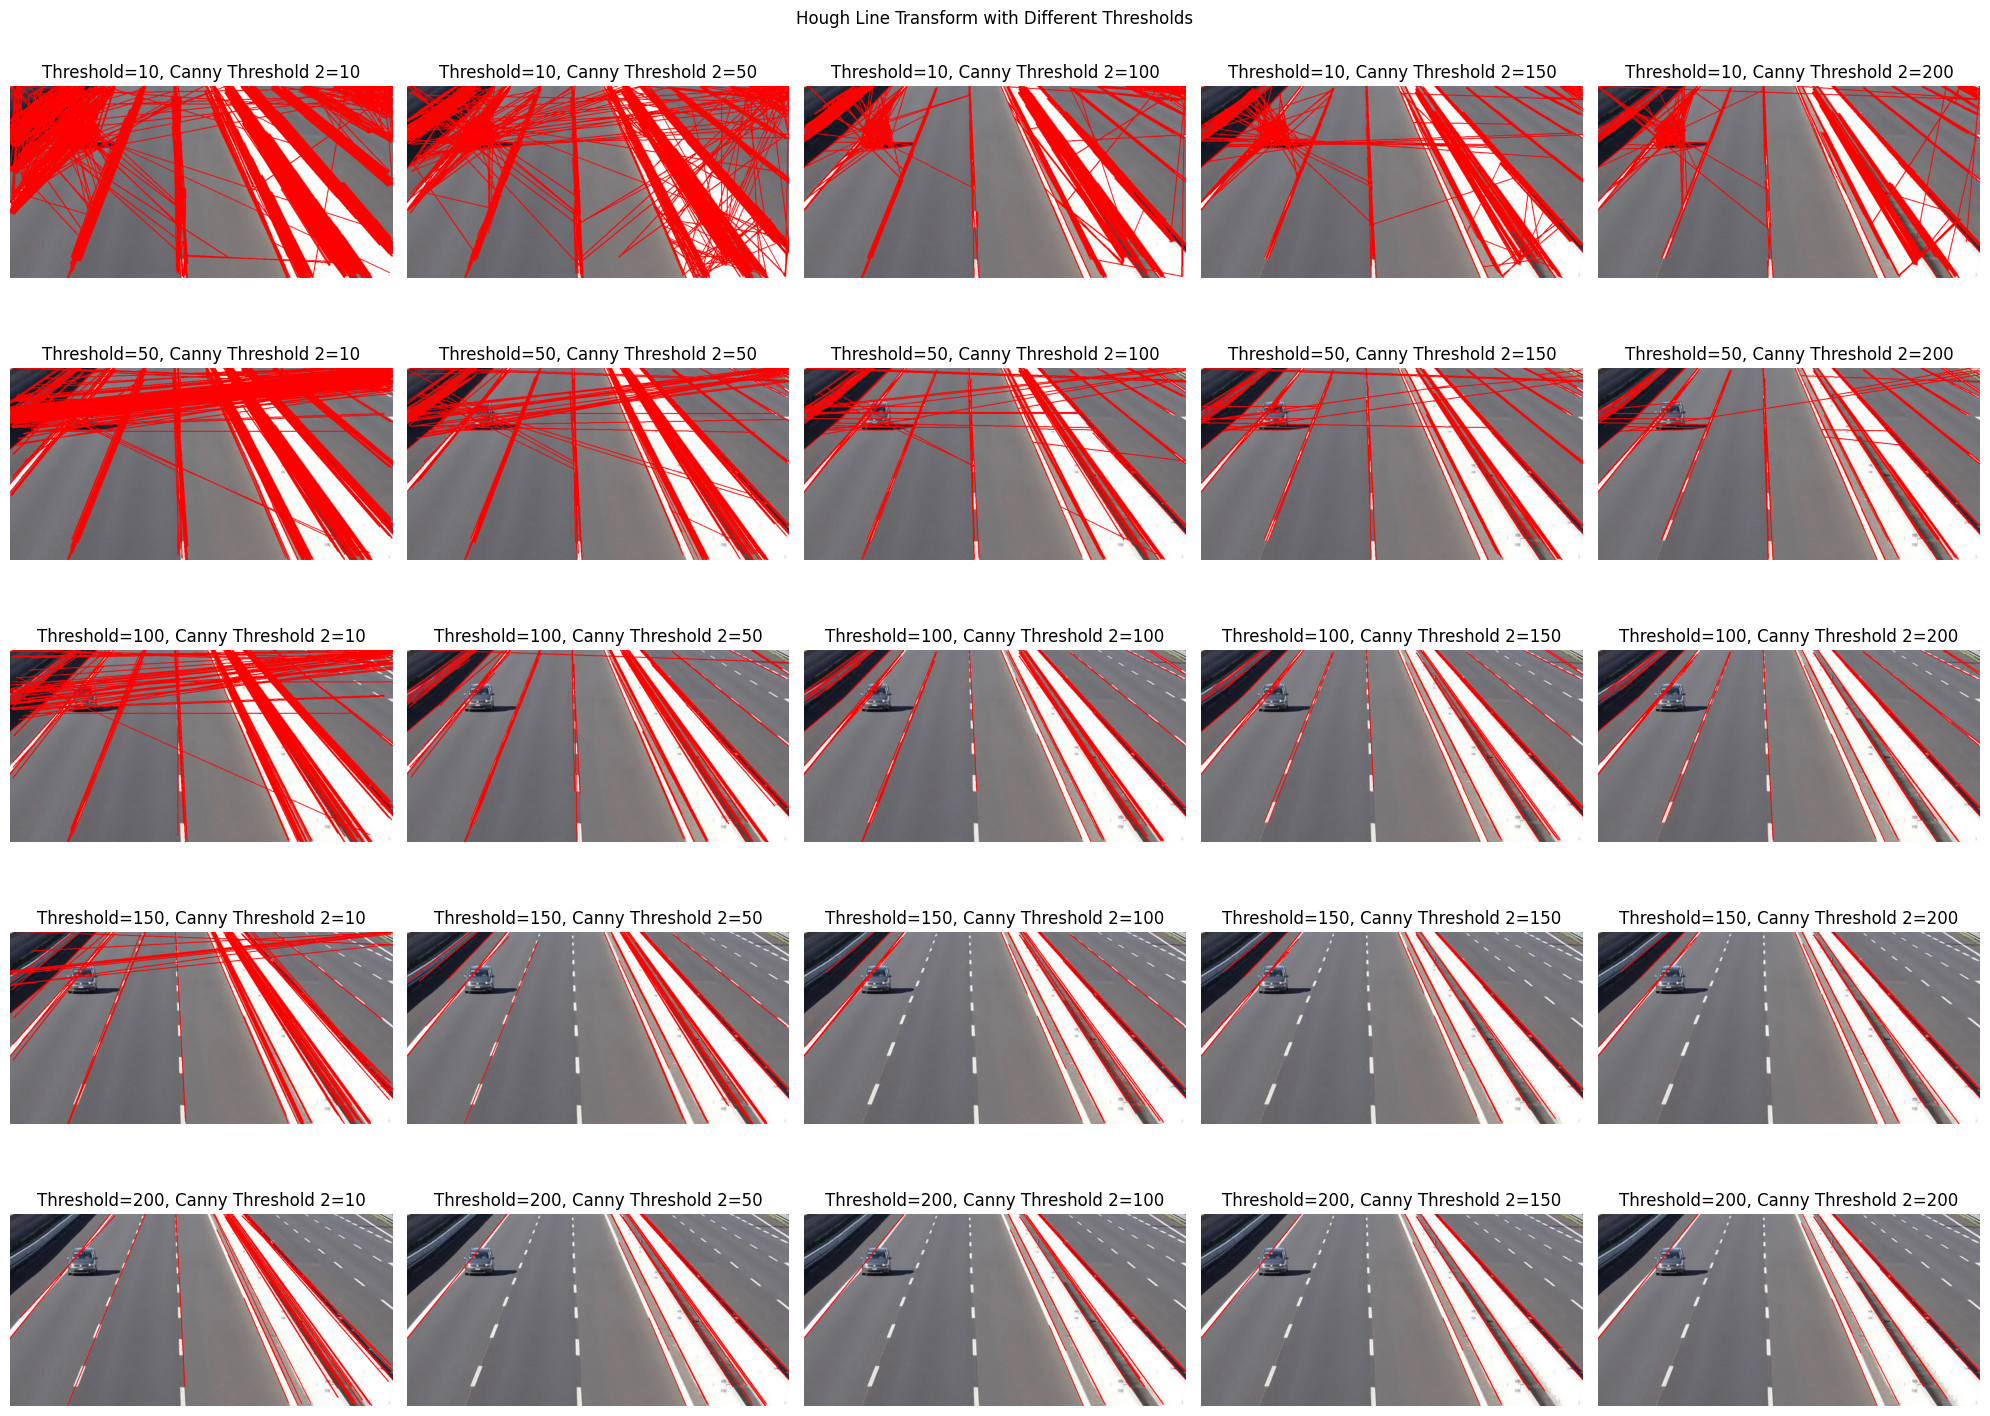

In [ ]:
# Testing different threshold values
thresholds = [10, 50, 100, 150, 200]
canny_threshold2_vals = [10, 50, 100, 150, 200]

fig, ax = plt.subplots(len(thresholds), len(canny_threshold2_vals), figsize=(20, 15))

for i, threshold in enumerate(thresholds):
    for j, canny_threshold2 in enumerate(canny_threshold2_vals):
        hough_line_transformed_img = hough_line_transform(lane_img, canny_threshold2=canny_threshold2, threshold=threshold)
        ax[i, j].imshow(hough_line_transformed_img)
        ax[i, j].set_title(f"Threshold={threshold}, Canny Threshold 2={canny_threshold2}")
        ax[i, j].axis("off")

plt.suptitle("Hough Line Transform with Different Thresholds")

plt.tight_layout()
plt.show()
plt.close(fig)

The `canny_threshold1` and `canny_threshold2` control edge sensitivity in Canny edge detection; `canny_threshold1` sets the minimum gradient, while `canny_threshold2` sets the stricter gradient threshold. The `threshold` in the Hough Transform dictates the minimum votes for a line to be detected. Higher values for `canny_threshold2` and `threshold` make detection stricter, reducing the number of detected lines but increasing confidence in the results.

## Task 3

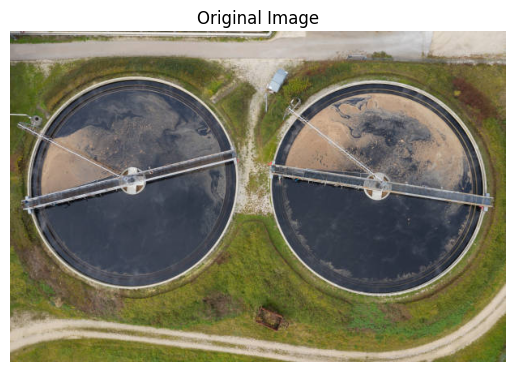

In [343]:
circle_img = cv2.imread("../images/circles.jpg")
circle_img = cv2.cvtColor(circle_img, cv2.COLOR_BGR2RGB)

plt.imshow(circle_img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.show()
plt.close()

In [ ]:
def hough_circle_transform(img, k=1, dp=1, min_dist=40, param1=100, param2=170, min_radius=50, max_radius=400):
    copy_img = np.copy(img)
    gray_img = cv2.cvtColor(copy_img, cv2.COLOR_BGR2GRAY) # Works on grayscale image
    img_blur = cv2.medianBlur(gray_img, k)                # Reducing noise

    circles = cv2.HoughCircles(
        img_blur,
        cv2.HOUGH_GRADIENT,     # Detection method
        dp=dp,                  # Inverse ratio of accumulator resolution to image resolution
        minDist=min_dist,       # Minimum distance between the centers of detected circles
        param1=param1,          # First threshold for the Canny edge detector
        param2=param2,          # Threshold for circle center detection (higher = fewer circles)
        minRadius=min_radius,
        maxRadius=max_radius
    )
    
    # Drawing circles on image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(copy_img, (i[0], i[1]), i[2], (0, 255, 0), 2) # Green Circumference
            cv2.circle(copy_img, (i[0], i[1]), 2, (0, 0, 255), 5)    # Red Center
    
    return copy_img, len(circles[0]) if circles is not None else 0

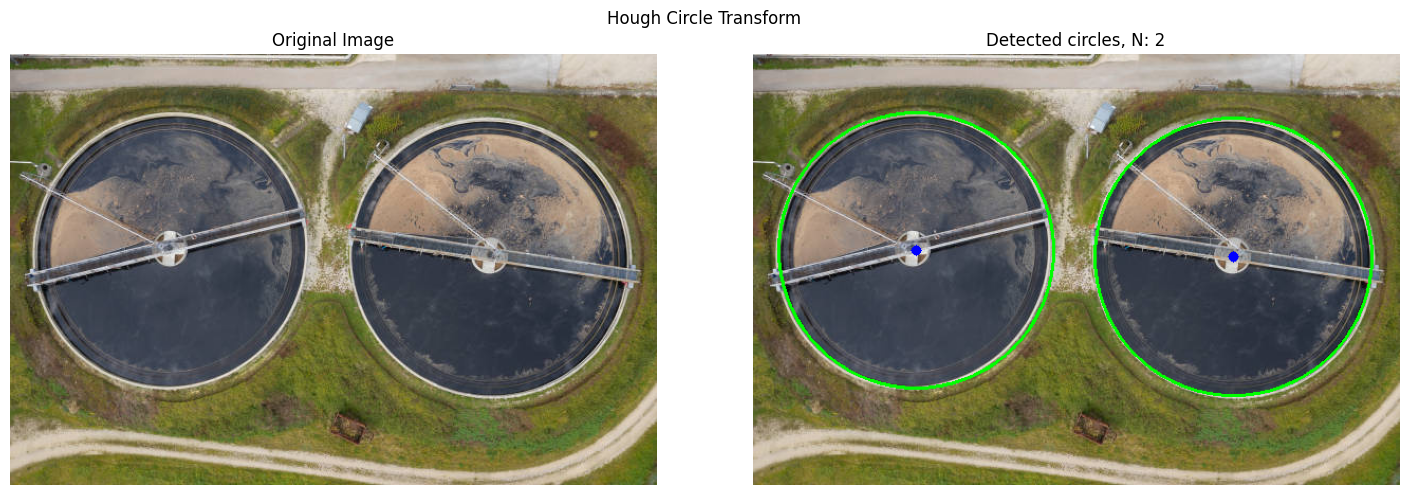

In [ ]:
hough_circle_transform_img, n_circles = hough_circle_transform(circle_img)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].imshow(circle_img)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(hough_circle_transform_img)
ax[1].set_title(f"Detected circles, N: {n_circles}")
ax[1].axis("off")

plt.suptitle("Hough Circle Transform")

plt.tight_layout()
plt.show()
plt.close(fig)

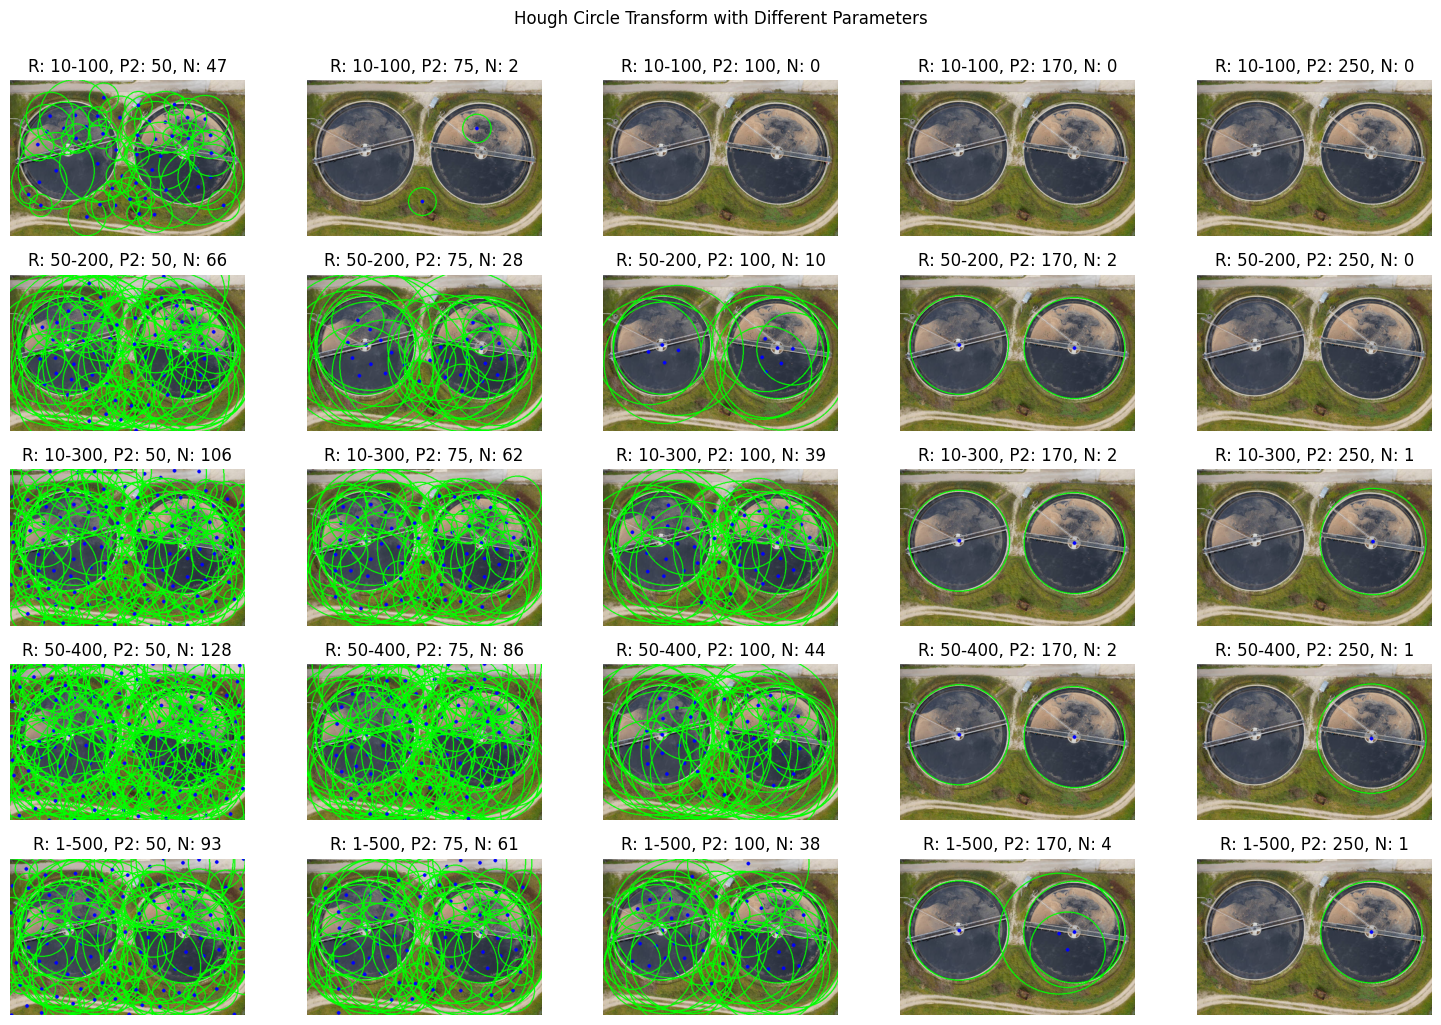

In [ ]:
# Testing different parameter combinations
radius_ranges = [[10, 100], [50, 200], [10, 300], [50, 400], [1, 500]]
param2_vals = [50, 75, 100, 170, 250]

# Plotting 5x5 grid
fig, axes = plt.subplots(len(radius_ranges), len(param2_vals), figsize=(15, 10))

for i, radius_range in enumerate(radius_ranges):
    for j, param2 in enumerate(param2_vals):
        min_radius, max_radius = radius_range
        hough_circle_img, n_circles = hough_circle_transform(circle_img.copy(), min_radius=min_radius, max_radius=max_radius, param2=param2)
    
        ax = axes[i, j]
        ax.imshow(hough_circle_img)
        ax.set_title(f"R: {min_radius}-{max_radius}, P2: {param2}, N: {n_circles}")
        ax.axis("off")

plt.suptitle("Hough Circle Transform with Different Parameters", y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()
plt.close(fig)

In the `hough_circle_transform` function, `min_radius` and `max_radius` define the range of circle sizes to detect, influencing which circles are considered valid. Smaller `min_radius` values allow detection of smaller circles, while larger `max_radius` values permit detection of bigger ones. Adjusting `param2`, which sets the threshold for circle center detection, significantly affects detection: higher `param2` values make the detection stricter, reducing the number of detected circles but improving accuracy, while lower values detect more circles, possibly including noise. Tuning these parameters helps optimize detection for images with varied circle sizes and noise levels.

## Task 4

In [ ]:
def harris_corner_detector(img, ksize=3, k=0.04, threshold=0.01):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                        # Works on grayscale
    gray_img = np.float32(gray_img)                                         # Requires float datatype
    corners = cv2.cornerHarris(gray_img, blockSize=ksize, ksize=ksize, k=k) # Applying algorithm
    corners = cv2.dilate(corners, None)                                     # Dialate for better visibility
    corner_img = np.copy(img)
    corner_img[corners > threshold * corners.max()] = [255, 0, 0]           # Red colored corners

    return corner_img

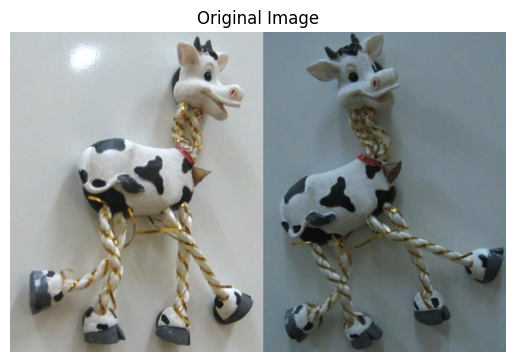

In [384]:
cow_img = cv2.imread("../images/cow.png")
cow_img = cv2.cvtColor(cow_img, cv2.COLOR_BGR2RGB)

plt.imshow(cow_img)
plt.title("Original Image")
plt.axis("off")

plt.show()
plt.close()

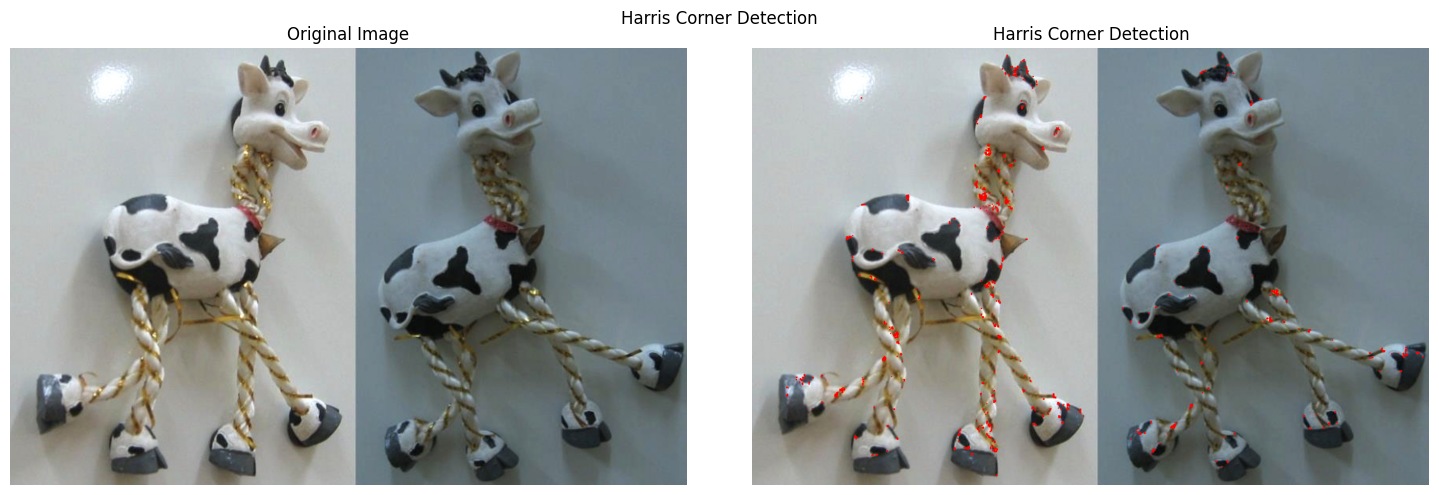

In [ ]:
harris_corner_detected_img = harris_corner_detector(cow_img)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].imshow(cow_img)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(harris_corner_detected_img)
ax[1].set_title("Harris Corner Detection")
ax[1].axis("off")

plt.suptitle("Harris Corner Detection")

plt.tight_layout()
plt.show()
plt.close(fig)

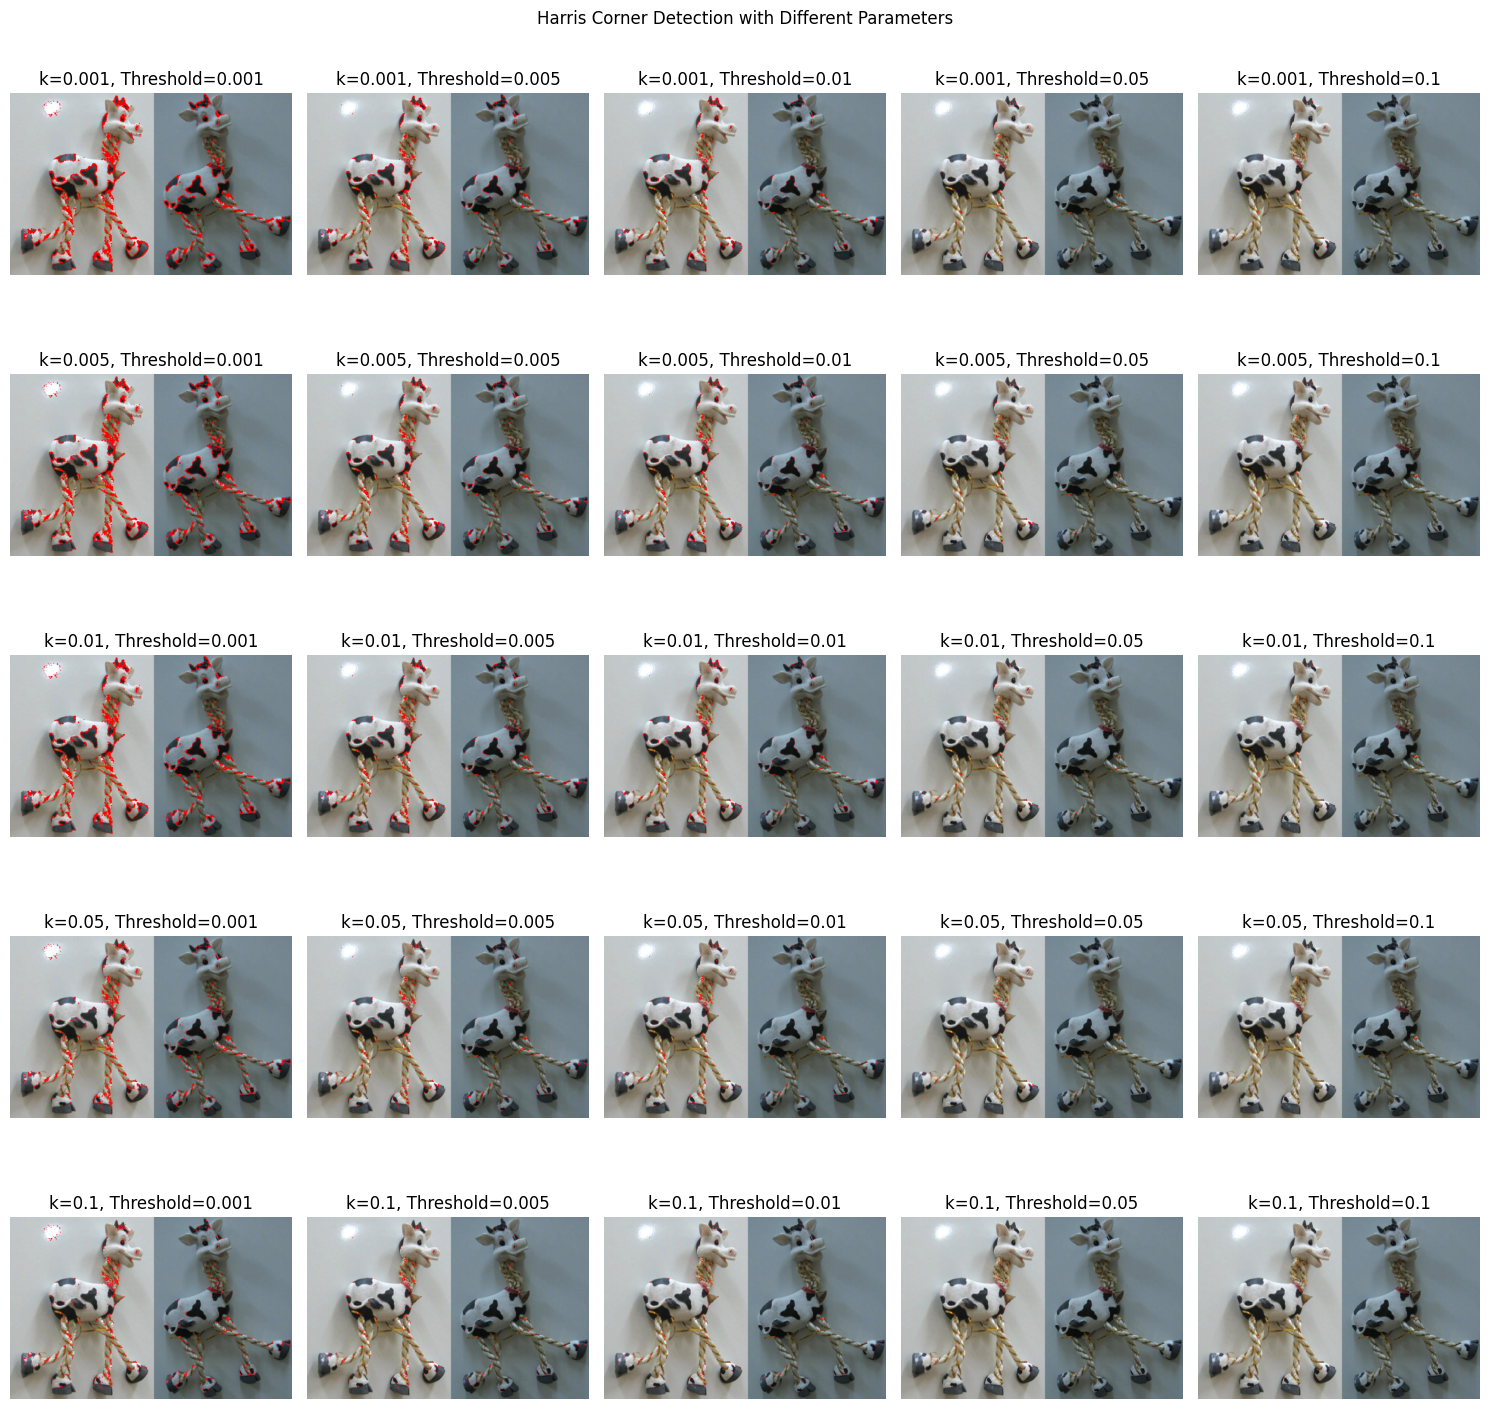

In [ ]:
# Varying the k value
k_arr = [0.001, 0.005, 0.01, 0.05, 0.1]
threshold_vals = [0.001, 0.005, 0.01, 0.05, 0.1]

fig, ax = plt.subplots(len(k_arr), len(threshold_vals), figsize=(15, 15))

for i, k in enumerate(k_arr):
    for j, threshold in enumerate(threshold_vals):
        harris_corner_detected_img = harris_corner_detector(cow_img, k=k, threshold=threshold)
        ax[i, j].imshow(harris_corner_detected_img)
        ax[i, j].set_title(f"k={k}, Threshold={threshold}")
        ax[i, j].axis("off")

plt.suptitle("Harris Corner Detection with Different Parameters")

plt.tight_layout()
plt.show()
plt.close(fig)

The `k` parameter in Harris corner detection controls sensitivity; lower `k` values detect more corners but may include noise, while higher `k` values make detection stricter. The `threshold` determines the minimum response to qualify as a corner; lower values detect more corners, including weaker ones, while higher values focus on strong corners but might miss subtle details. Adjusting these parameters helps balance corner detection between capturing detail and reducing false positives.

## Task 5

The Hough Transform differs for detecting lines versus circles mainly in the parameter space and computational complexity. For line detection, the transform maps points in the image space to a 2D parameter space defined by distance (`rho`) and angle (`theta`). This approach is efficient and simpler in terms of computation. In contrast, circle detection requires a 3D parameter space (center coordinates `x`, `y`, and radius `r`), increasing complexity and memory usage. The search for circles is more computationally intensive due to the added dimension, making it slower compared to line detection. Overall, while line detection works with fewer parameters, circle detection involves more detailed searches to locate and validate circular shapes.